# Two-Fluids SBN with input images vs analytical

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os

import sys
sys.path.append(r'E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\lab-logbooks\LAB_base_methods_temp')

%aimport slm_controllers
%aimport camera_controllers
%aimport RC_methods


from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from matplotlib.colors import ListedColormap

from scipy import optimize
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import warnings
warnings.filterwarnings('ignore')


def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='blue'>System parameters - configuration</font>

$P_{fluid}=$46.8$\mu W$
$P_{obs}=$71.3$\mu W$
$c_s=$0.0036
$v=$0.003
$v/c_s=$0.8348
$\xi=$9.9$\mu m$


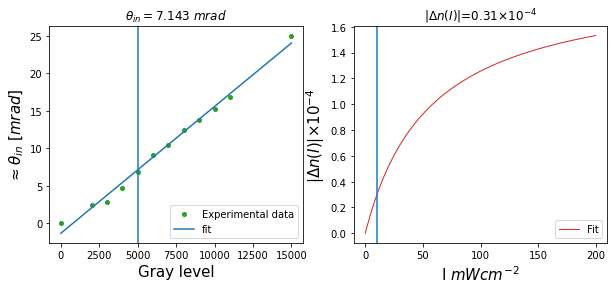

In [31]:
#%matplotlib widget
%matplotlib inline

#########################################################################################################
#Velocity of the fluid
GL = 5000

#Green beam parameters
P_green_beam = 46.8 #muW
w = 615e-4 #cm

#Red beam parameters
P_red_beam = 71.3 #muW
d_bessel = 121.9e-4 #cm

#Scaling factor of the power meter
power_meter_factor = 1.34

#########################################################################################################

I_fluid = power_meter_factor*P_green_beam*1e-3*2/(np.pi*w**2.0)

r_bessel = d_bessel/2.0
I_defect = P_red_beam*1e-3/(np.pi*r_bessel**2.0)

fig = plt.figure(figsize=(10, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

plt.title("$\\theta_{in}=$" + str(np.round(linear_fit(np.array(GL), *popt_x_ve)/(1e-3),3)) + " $mrad$")
plt.plot(GL_to_load, np.array(angle)/(1e-3), linewidth=0, marker="o", markersize=4, color="tab:green", label="Experimental data")
plt.plot(GL_to_load, linear_fit(np.array(GL_to_load), *popt_x_ve)/(1e-3), label="fit")
plt.xlabel("Gray level", fontsize=15)
plt.ylabel("$\\approx\\theta_{in}$ $[mrad]$", fontsize=15)
plt.axvline(x=GL)

plt.legend(loc=0)   

plt.subplot(grid[0, 1])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])



plt.title("|$\Delta n(I)$|=" + str(np.round(delta_n_f(I_fluid, *delta_n_params)/(1e-4),3)) + "$\\times 10^{-4}$")

I_theo = np.linspace(0, 200)
plt.plot(I_theo, delta_n_f(I_theo, *delta_n_params)/1e-4, linewidth=1, label='Fit', color="tab:red")
plt.axvline(x=I_fluid)
plt.xlabel("I $mWcm^{-2}$", fontsize=15)
plt.ylabel("|$\Delta n(I)$|$\\times 10^{-4}$", fontsize=15)
plt.legend(loc=0)

plt.tight_layout()

ne = 2.36
k0 = 2.0*np.pi/(532e-9)
cs = np.sqrt(delta_n_f(I_fluid, *delta_n_params)/ne)
fluid_velocity = linear_fit(np.array(GL), *popt_x_ve)/ne
healing_length = 1.0/(ne*k0*cs)

print("$P_{fluid}=$" + str(P_green_beam) + "$\mu W$")
print("$P_{obs}=$" + str(P_red_beam) + "$\mu W$")
print("$c_s=$" + str(np.round(cs,4)))
print("$v=$" + str(np.round(fluid_velocity,4)))
print("$v/c_s=$" + str(np.round(fluid_velocity/cs,4)))
print("$\\xi=$" + str(np.round(healing_length/(1e-6),2)) + "$\\mu m$")

# <font color='blue'>Measure input fluid and optical obstacle</font>

In [4]:
#Initializate camera
input_camera = 16046
camera = camera_controllers.camera_system('Thorlabs', input_camera)

#Set some camera properties
properties = {'exposure':250, 'image_poll_timeout_ms':10000, 'num_frames':1, 
              'frames_per_trigger_zero_for_unlimited':5, 'binx':2, 'biny':2}

camera.set_properties(properties)

camera.get_camera_ready()


input_fluid = camera.get_image()

#Close camera
camera.close()

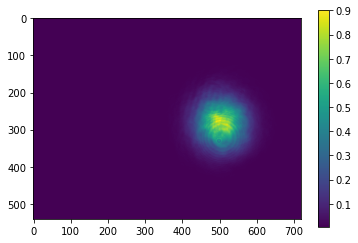

In [5]:
#%matplotlib widget
%matplotlib inline

plt.figure()
plt.imshow(input_fluid)
plt.colorbar()

In [6]:
#Initializate camera
input_camera = 16046
camera = camera_controllers.camera_system('Thorlabs', input_camera)

#Set some camera properties
properties = {'exposure':150, 'image_poll_timeout_ms':10000, 'num_frames':1, 
              'frames_per_trigger_zero_for_unlimited':5, 'binx':2, 'biny':2}

camera.set_properties(properties)

camera.get_camera_ready()


input_axicon = camera.get_image()

#Close camera
camera.close()

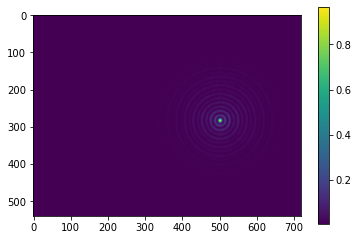

In [8]:
#%matplotlib widget
%matplotlib inline

plt.figure()
plt.imshow(input_axicon)
plt.colorbar()

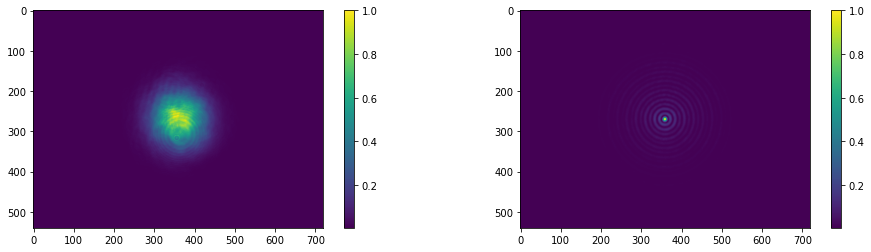

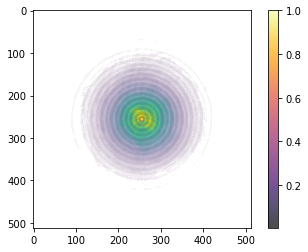

In [9]:
#matplotlib widget
%matplotlib inline

x_center_axicon = 503
y_center_axicon = 283

y_shape, x_shape = np.shape(input_fluid)

input_fluid_rolled = np.roll(np.roll(input_fluid, int(x_shape/2.0) - x_center_axicon, 1), 
                              int(y_shape/2.0) - y_center_axicon, 0)


input_axicon_rolled = np.roll(np.roll(input_axicon, int(x_shape/2.0) - x_center_axicon, 1),
                              int(y_shape/2.0) - y_center_axicon, 0)

fig = plt.figure(figsize=(16, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)


plt.subplot(grid[0, 0])
input_fluid_normalized = input_fluid_rolled/np.max(input_fluid_rolled)
plt.imshow(input_fluid_normalized)
plt.colorbar()

plt.subplot(grid[0, 1])
input_axicon_normalized = input_axicon_rolled/np.max(input_axicon_rolled)
plt.imshow(input_axicon_normalized)
plt.colorbar()


input_fluid_normalized_cutted = input_fluid_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]
input_axicon_normalized_cutted = input_axicon_normalized[:,(int(x_shape/2.0) - int(y_shape/2.0)):(int(x_shape/2.0) + int(y_shape/2.0))]

y_shape_cutted, x_shape_cutted = np.shape(input_fluid_normalized_cutted)

input_fluid_normalized_cutted = input_fluid_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]
input_axicon_normalized_cutted = input_axicon_normalized_cutted[(int(y_shape_cutted/2.0) - 256):(int(y_shape_cutted/2.0) + 256),(int(x_shape_cutted/2.0) - 256):(int(x_shape_cutted/2.0) + 256)]

#input_fluid_normalized_cutted = np.transpose(input_fluid_normalized_cutted)
#input_axicon_normalized_cutted = np.transpose(input_axicon_normalized_cutted)

plt.figure()

cmap_fluid = plt.cm.viridis
my_cmap_fluid = cmap_fluid(np.arange(cmap_fluid.N))
my_cmap_fluid[:, -1] = np.linspace(0, 1, cmap_fluid.N)**0.5
my_cmap_fluid = ListedColormap(my_cmap_fluid)

cmap_obstacle = plt.cm.inferno
my_cmap_obstacle = cmap_obstacle(np.arange(cmap_obstacle.N))
my_cmap_obstacle[:, -1] = np.linspace(0, 1, cmap_obstacle.N)**0.5
my_cmap_obstacle = ListedColormap(my_cmap_obstacle)

plt.imshow(input_fluid_normalized_cutted, cmap=my_cmap_fluid)
plt.imshow(input_axicon_normalized_cutted, cmap=my_cmap_obstacle, alpha=0.7)
plt.colorbar()

# <font color='blue'>Calculate simulation parameters</font>

In [32]:
#simulation beam power
If1= I_fluid #mw/cm^-2 fluid beam
If2 = I_defect/If1 #mw/cm^-2 defect
Isat = delta_n_params[-1]/If1 #mw/cm^-2

#light fluid wavelength
lf=532*10**-9

#k_fluid
kf = (2*pi)/(lf)

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33 = 235*10**-12 #pm/V
#Biasing electric Field
E0 = 1400*10**2 # V/m

#maximum index variation
#delta_n_max = 0.5*ne**3*r33*E0
delta_n_max = delta_n_params[0]
delta_n = delta_n_f(I_fluid, *delta_n_params)


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n)

#propagation direction scaling factor
factor_z = kf*delta_n

##################################################
#Crystal Size
lx=512*3.45*1e-6*2 #2.5*10**-3
ly=512*3.45*1e-6*2 #2.5*10**-3
lz=20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz


lx_an=2.5*10**-3
ly_an=2.5*10**-3
lz_an=20*10**-3

#in adimensional units
lx_sim_an = factor_t*lx_an
ly_sim_an = factor_t*ly_an
lz_sim_an = factor_z*lz_an

# <font color='blue'>Create simulation mesh</font>

Define the simulation box parameters

In [33]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.

#spatial steps
dx_an = lx_sim_an / Nx
dy_an = ly_sim_an / Ny
dt = 1.

#integration parameters

stride = 50
dz = 0.005 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = r".turbulence_photorefractive_with_images"
saveDir_an = r".turbulence_photorefractive_analytical"

29


# <font color='blue'>Create simulation initial conditions</font>

In [55]:
#Simulation parameters

waist_sim = w*1e-2*factor_t

#dd = 115.3*10**-6*factor_t #bessel
#dd2 = 239*10**-6*factor_t #bessel

dd = d_bessel*1e-2*factor_t/2.0

#cs = np.sqrt(1/Isat)
vx = (fluid_velocity*ne)/np.sqrt(ne*delta_n)
gamma = 1


print("vx = " + str(vx))

print("bessel diameter = " + str(dd))

##################################################################################################################

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

#Gaussian field - fluid
my_simulation.initial_condition.add_field(add_field_from_array_with_velocity(np.sqrt(input_fluid_normalized_cutted),
                                                                             my_simulation.x_af,
                                                                             my_simulation.y_af, 
                                                                             1.0,
                                                                             my_simulation.Nx*my_simulation.dx/2, 
                                                                             my_simulation.Ny*my_simulation.dy/2,
                                                                             vx,
                                                                             0))



#Axicon - optical defect
my_simulation.initial_condition2.add_field(add_field_from_array_with_velocity(np.sqrt(input_axicon_normalized_cutted),
                                                                              my_simulation.x_af,
                                                                              my_simulation.y_af, 
                                                                              If2**(1.0/2.0),
                                                                              my_simulation.Nx*my_simulation.dx/2,
                                                                              my_simulation.Ny*my_simulation.dy/2,
                                                                              0,
                                                                              0))

##################################################################################################################

my_simulation_an = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride, dx_an, dy_an, dz, dt, 0, 0, 
                                  alpha, Isat, gamma, saveDir_an)

#Gaussian field - fluid
my_simulation_an.initial_condition.add_field(gaussian_2d_field(my_simulation_an.x_af,my_simulation_an.y_af,1.0,waist_sim,
                                                                Nx*dx_an/2,Ny*dy_an/2,vx,0))

#Noise
my_simulation_an.initial_condition.add_field(whitenoise_2d_field(my_simulation_an.x_af, 0.1))

#Axicon - optical defect
my_simulation_an.initial_condition2.add_field(bessel_2d(my_simulation_an.x_af,my_simulation_an.y_af, If2**2.0,
                                    my_simulation_an.Nx*dx_an/2, my_simulation_an.Ny*dy_an/2, dd))


##################################################################################################################


#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

vx = 0.8348386161171404
bessel diameter = 6.158932995815591


# <font color='blue'>Test simulation initial conditions</font>

1.7595000000000003
-1.7664


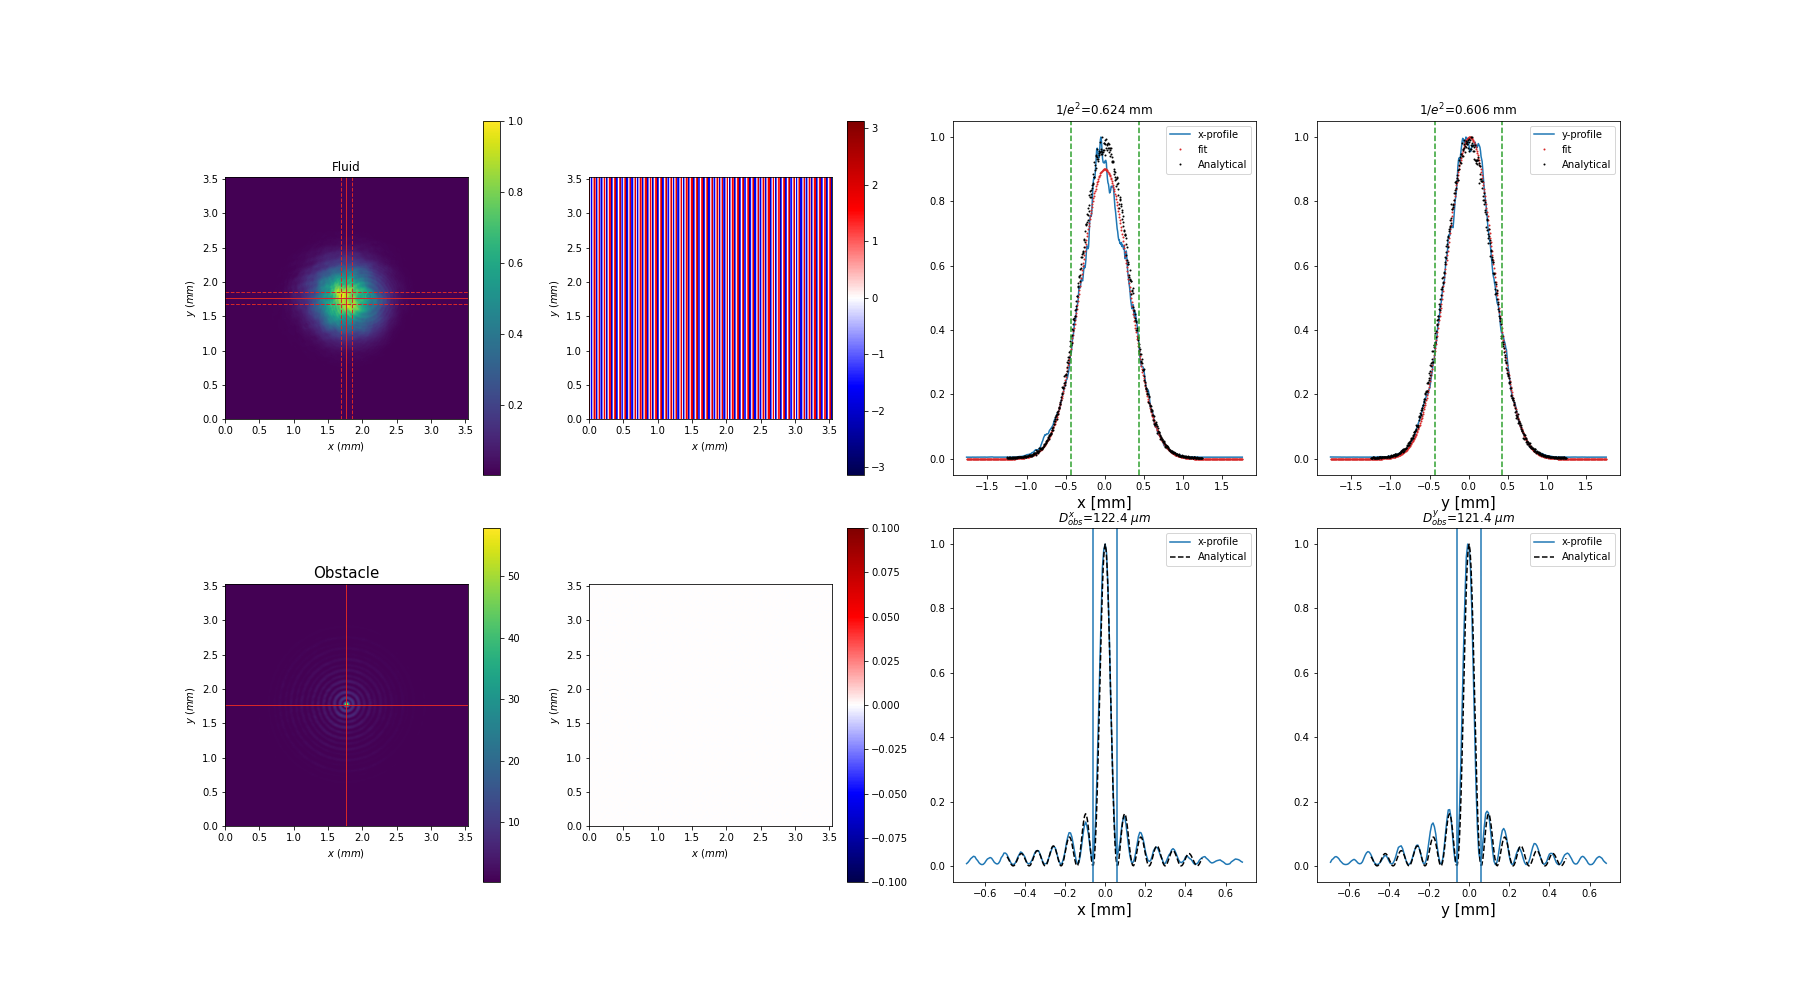

In [56]:
%matplotlib widget
#%matplotlib inline

######################### Gausian

extent_general = [0, Nx*dx/factor_t/(1e-3), 0, Ny*dy/factor_t/(1e-3)]

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
phase_input_beam = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition.np_array), np.real(my_simulation.initial_condition.np_array)))

input_beam_profile_an = np.transpose(np.abs(my_simulation_an.initial_condition.np_array)**2.0)

y_shape, x_shape = np.shape(input_beam_profile)

dx_units = 1440 / x_shape
dy_units = 1080 / y_shape

x_center_4f = 256
y_center_4f = 256

width_mean = 12

profile_x = input_beam_profile[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y = input_beam_profile[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x = np.mean(profile_x, axis=0)
profile_y = np.mean(profile_y, axis=1)

profile_x_an = input_beam_profile_an[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y_an = input_beam_profile_an[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x_an = np.mean(profile_x_an, axis=0)
profile_y_an = np.mean(profile_y_an, axis=1)



# profile_x = input_beam_profile[y_center, :]
# profile_y = input_beam_profile[:, x_center]


profile_x = profile_x/np.max(profile_x)
profile_y = profile_y/np.max(profile_y)

profile_x_an = profile_x_an/np.max(profile_x_an)
profile_y_an = profile_y_an/np.max(profile_y_an)


x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

x_array_an = np.array(my_simulation_an.x_af)[:, y_center_4f] - np.array(my_simulation_an.x_af)[x_center_4f, y_center_4f]
y_array_an = np.array(my_simulation_an.y_af)[x_center_4f, :] - np.array(my_simulation_an.y_af)[x_center_4f, y_center_4f]

print(np.max(x_array)/factor_t/(1e-3))
print(np.min(x_array)/factor_t/(1e-3))

popt_x, pcov_x = sp.optimize.curve_fit(gaus, x_array, profile_x, p0=[1,0,30.0])

popt_y, pcov_y = sp.optimize.curve_fit(gaus, y_array, profile_y, p0=[1,0,30.0])



fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Fluid")
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.axvline(x=(x_center_4f)*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axvline(x=(x_center_4f - width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axvline(x=(x_center_4f + width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.axhline(y=(y_center_4f)*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=(y_center_4f - width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axhline(y=(y_center_4f + width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.subplot(grid[0, 1])
plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 2])
plt.title("$1/e^2$=" + str(np.round(popt_x[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(x_array/factor_t/(1e-3), profile_x, label="x-profile", color="tab:blue")
plt.plot(x_array/factor_t/(1e-3), gaus(x_array, *popt_x),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.plot(x_array_an/factor_t/(1e-3),profile_x_an,'ro:', linewidth=0, markersize=1, color="black", linestyle="--", label="Analytical")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=(popt_x[-1] + popt_x[1])*dx/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_x[-1] + popt_x[1])*dx/factor_t/(1e-3), color="tab:green", linestyle="--")

plt.subplot(grid[0, 3])
plt.title("$1/e^2$=" + str(np.round(popt_y[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(y_array/factor_t/(1e-3), profile_y, label="y-profile", color="tab:blue")
plt.plot(y_array/factor_t/(1e-3), gaus(y_array, *popt_y),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.plot(y_array_an/factor_t/(1e-3),profile_y_an,'ro:', linewidth=0, markersize=1, color="black", linestyle="--", label="Analytical")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=(popt_y[-1] + popt_y[1])*dy/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_y[-1] + popt_y[1])*dy/factor_t/(1e-3), color="tab:green", linestyle="--")



#######################          Axicon
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
phase_axicon = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition2.np_array), np.real(my_simulation.initial_condition2.np_array)))

input_axicon_size_an = np.transpose(np.abs(my_simulation_an.initial_condition2.np_array)**2.0)

y_shape, x_shape = np.shape(input_axicon_size)


x_center_4f = 256
y_center_4f = 256

fit_width = 100

x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]



profile_x_4f_input_axicon_size = input_axicon_size[y_center_4f, :]
profile_y_4f_input_axicon_size = input_axicon_size[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size_cutted/np.max(profile_x_4f_input_axicon_size_cutted)
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size_cutted/np.max(profile_y_4f_input_axicon_size_cutted)

x_array_cutted_4f = x_array[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f = y_array[(y_center_4f-fit_width):((y_center_4f+fit_width))]

popt_x_input_4f, pcov_x_input = sp.optimize.curve_fit(bessel_function, x_array_cutted_4f, profile_x_4f_input_axicon_size_cutted, p0=[0, 10.0])
popt_y_input_4f, pcov_y_input = sp.optimize.curve_fit(bessel_function, y_array_cutted_4f, profile_y_4f_input_axicon_size_cutted, p0= [0, popt_x_input_4f[-1]])


profile_x_4f_input_axicon_size_an = input_axicon_size_an[y_center_4f, :]
profile_y_4f_input_axicon_size_an = input_axicon_size_an[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted_an = profile_x_4f_input_axicon_size_an[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted_an = profile_y_4f_input_axicon_size_an[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted_an = profile_x_4f_input_axicon_size_cutted_an/np.max(profile_x_4f_input_axicon_size_cutted_an)
profile_y_4f_input_axicon_size_cutted_an = profile_y_4f_input_axicon_size_cutted_an/np.max(profile_y_4f_input_axicon_size_cutted_an)

x_array_cutted_4f_an = x_array_an[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f_an = y_array_an[(y_center_4f-fit_width):((y_center_4f+fit_width))]


######################################################################################################################################################

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")


plt.subplot(grid[1, 2])
plt.title("$D^x_{obs}$=" + str(2.0*np.round(popt_x_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), profile_x_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
#plt.plot(x_array_cutted_4f/factor_t/(1e-3), bessel_function(x_array_cutted_4f, *popt_x_input_4f), label='fit', color="tab:red")
plt.plot(x_array_cutted_4f_an/factor_t/(1e-3), profile_x_4f_input_axicon_size_cutted_an, label='Analytical', color="black", linestyle="--")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=popt_x_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_x_input_4f[-1]/factor_t/(1e-3))


plt.subplot(grid[1, 3])
plt.title("$D^y_{obs}$=" + str(2.0*np.round(popt_y_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), profile_y_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
#plt.plot(y_array_cutted_4f/factor_t/(1e-3), bessel_function(y_array_cutted_4f, *popt_y_input_4f), label='fit', color="tab:red")
plt.plot(y_array_cutted_4f_an/factor_t/(1e-3), profile_y_4f_input_axicon_size_cutted_an, label='Analytical', color="black", linestyle="--")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=popt_y_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_y_input_4f[-1]/factor_t/(1e-3))

plt.tight_layout()

In [23]:
(0.624 + 0.606)/2.0

0.615

In [30]:
(122.4+121.4)/2.0

121.9

In [45]:
0.0623-0.0442

0.018099999999999998

# <font color='blue'>Generate Configuration file</font>

In [38]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)
my_simulation_an.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


# <font color='blue'>Set device to compute</font>

In [39]:
af.device.set_device(0)
af.device.device_info()

{'device': 'GeForce_GTX_TITAN',
 'backend': 'OpenCL',
 'toolkit': 'NVIDIA CUDA',
 'compute': '1.2'}

# <font color='blue'>Run Simulation</font>

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [398]:
%%cmd
envelope.exe 2 0

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation. All rights reserved.

(LAB_env) E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\SBN>envelope.exe 2 0
ArrayFire v3.6.4 (OpenCL, 64-bit Windows, build 1b8030c)
[0] NVIDIA: GeForce GTX TITAN, 6144 MB
Running info
ArrayFire v3.6.4 (OpenCL, 64-bit Windows, build 1b8030c)
[0] NVIDIA: GeForce GTX TITAN, 6144 MB
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 29
update Stride 1 of 29
update Stride 2 of 29
update Stride 3 of 29
update Stride 4 of 29
update Stride 5 of 29
update Stride 6 of 29
update Stride 7 of 29
update Stride 8 of 29
update Stride 9 of 29
update Stride 10 of 29
update Stride 11 of 29
update Stride 12 of 29
update Stride 13 of 29
update Stride 14 of 29
update Stride 15 of 29
update Stride 16 of 29
update Stride 17 of 29
update Stride 18 of 29
update Stride 19 of 29
update Stride 20 of 29
update Stride 21 of 29
update Stride 22 of 29
update Stride 2

# <font color='blue'>Load data</font>

In [399]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1
simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)
simulation_data2,zs = load_data_folder(saveDir+"/gnlse_field2/",my_mesh,stride_read)

# <font color='blue'>Plot results</font>

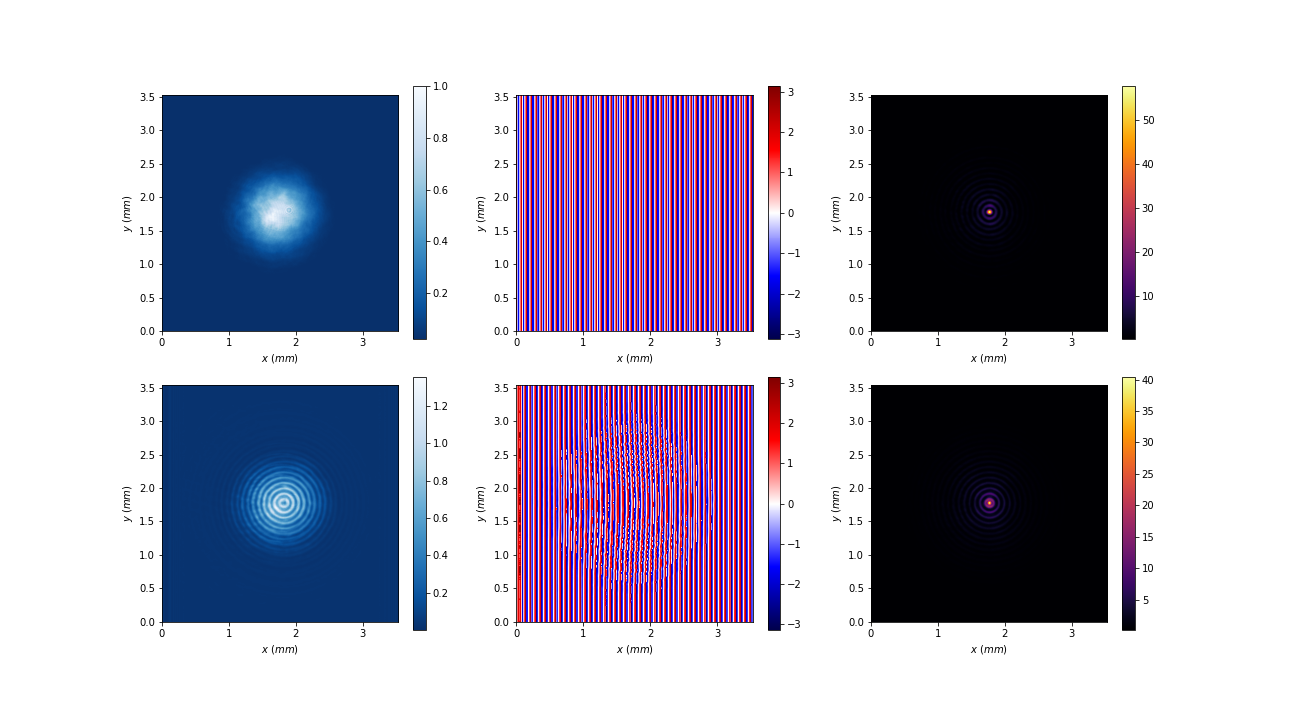

In [400]:
%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 3

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

im = imshow(transpose(abs(simulation_data[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 2])
im1 = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

plt.subplot(grid[1, 0])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 2])
im1 = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

fig.tight_layout()


# <font color='blue'>Plot results - arround the defect</font>

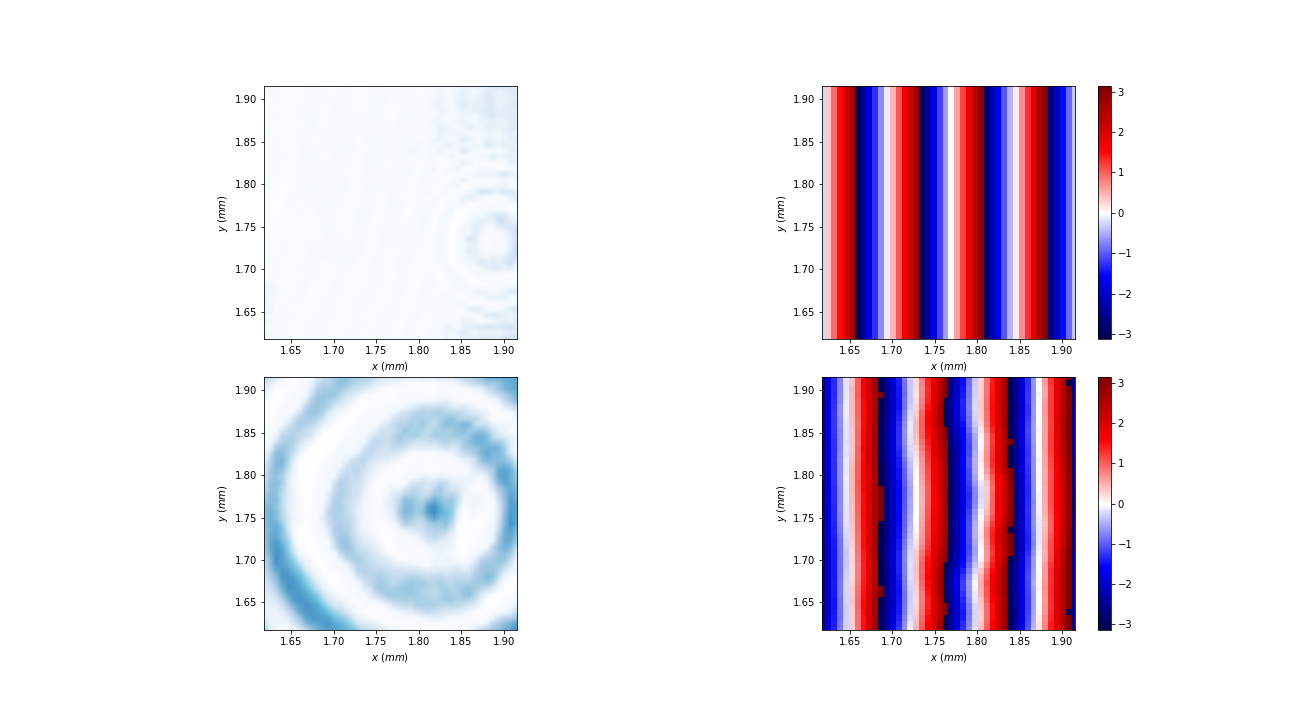

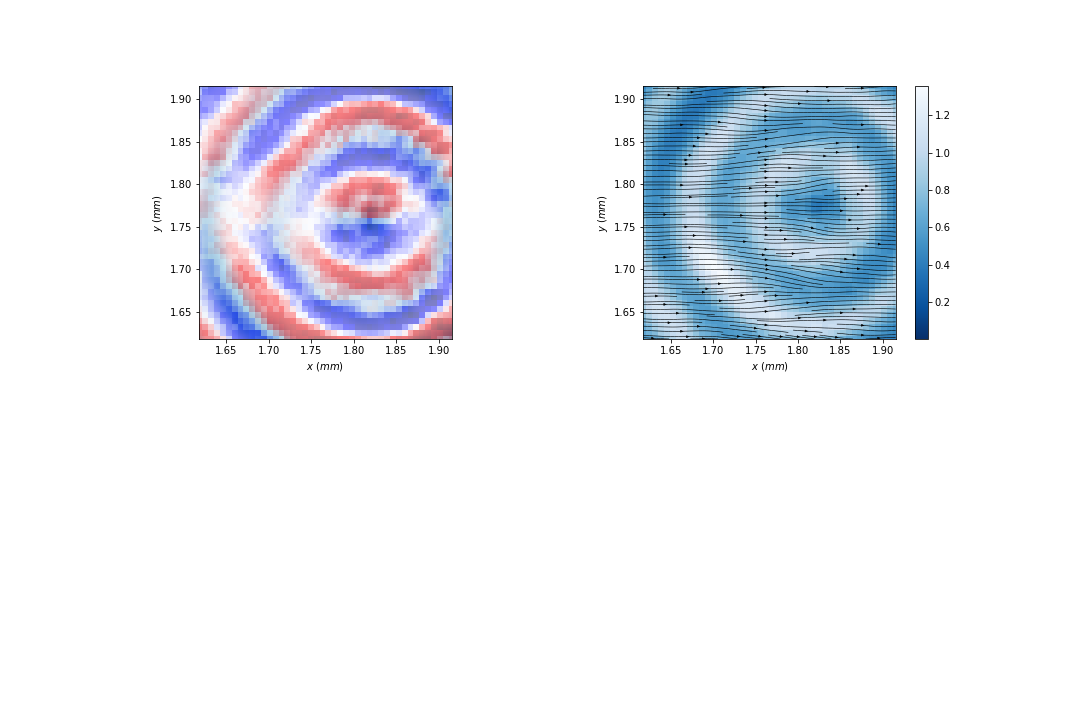

In [401]:
%matplotlib widget
#%matplotlib inline

x_center = my_mesh.lx/factor_t/(1e-3)/2.0
y_center = my_mesh.ly/factor_t/(1e-3)/2.0

width_arround_defect = 15
width_arround_defect = width_arround_defect/factor_t/(1e-3)

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

data_temp = transpose(abs(simulation_data[0])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(np.transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig = plt.figure(figsize=(15, 10))

rows = 1
columns = 2

plt.subplot(grid[0, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

vorticity = get_vorticity(np.transpose(simulation_data[-1]), my_mesh.dx, my_mesh.dy)

plt.imshow(vorticity, cmap="seismic", extent = extent_general, 
       aspect = "equal", alpha=0.5)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)


XX, YY = np.meshgrid(np.linspace(0, extent_general[1], x_shape), np.linspace(0, extent_general[-1], y_shape))
px, py = get_momentum_vector_2d(np.transpose(simulation_data[-1]), my_mesh.dx/factor_t, my_mesh.dy/factor_t)

arrays = np.where( ((XX>=(x_center - width_arround_defect))&(XX<=(x_center + width_arround_defect)))&
                   ((YY>=(y_center - width_arround_defect))&(YY<=(y_center + width_arround_defect))) )



XX_cutted = XX[arrays]
YY_cutted = YY[arrays]
px_cutted = px[arrays]
py_cutted = py[arrays]

shape = int(np.sqrt(np.shape(XX_cutted)[0]))

XX_cutted = np.reshape(XX_cutted,(shape, shape))
YY_cutted = np.reshape(YY_cutted,(shape, shape))
px_cutted = np.reshape(px_cutted,(shape, shape))
py_cutted = np.reshape(py_cutted,(shape, shape))

plt.streamplot(XX_cutted, YY_cutted, px_cutted, py_cutted, color="k", linewidth=0.6, density=2, arrowsize=0.5)

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig.tight_layout()



# <font color='blue'>Plot incompressible kinetic energy</font>

In [214]:
k_collection = []
E_incom_collection = []

manager = enlighten.get_manager()
ticks = manager.counter(total=len(simulation_data), desc="Calculating data", unit="it", color="blue")

for i in range(len(simulation_data)):

    r_temp, Eci_temp, ecc_temp = get_field_turbulence_properties_single_field(np.transpose(simulation_data[i]), my_mesh.dx/factor_t, my_mesh.dx/factor_t, k_n=128)
    
    k_collection.append(r_temp[1:])
    E_incom_collection.append(Eci_temp[1:])
    
    ticks.update()
        
manager.stop()

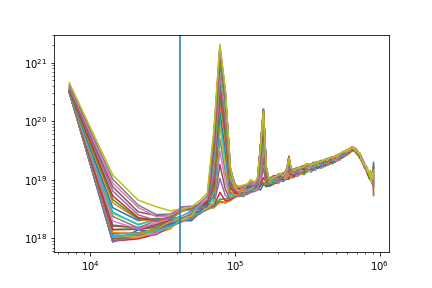

In [218]:
plt.figure()
for i in range(len(simulation_data)):
    plt.plot(k_collection[i], E_incom_collection[i])
    
plt.axvline(x=2.0*np.pi/(width_arround_defect*1e-3))  
    
plt.xscale("log")
plt.yscale("log")